# Erzeugung von Zufallszahlen

## Normalverteilte Zufallszahlen

In [1]:
import numpy

In [2]:
!pip install numpy

In [11]:
A = numpy.random.normal(loc=0.0, scale=1.0, size=10000)

In [12]:
A[:10]

array([-1.56669686, -0.24350898,  1.1499306 ,  0.64031271, -1.3104449 ,
       -2.6674762 ,  1.76917861, -0.31524475,  1.51404834,  0.63434226])

In [13]:
A.shape

(10000,)

In [14]:
A.ndim

1

In [15]:
numpy.mean(A)

np.float64(0.011263889792106843)

In [16]:
numpy.std(A)

np.float64(1.0079939572338423)

In [18]:
numpy.min(A)

np.float64(-3.7373144399406573)

In [19]:
numpy.max(A)

np.float64(3.7923895808727663)

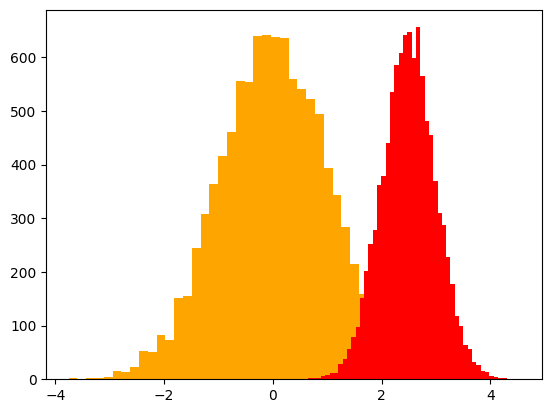

In [25]:
import matplotlib.pyplot as plt
A = numpy.random.normal(loc=0.0, scale=1.0, size=10000)
B = numpy.random.normal(loc=2.5, scale=0.5, size=10000)
plt.hist(A, bins=50, color="orange")
plt.hist(B, bins=50, color="red")
plt.show()

## Gleichverteilte Zufallszahlen

In [34]:
[numpy.random.randint(low=-3, high=+3) for _ in range(10)]

[-1, -2, 0, 1, -3, -1, -1, -2, -3, 0]

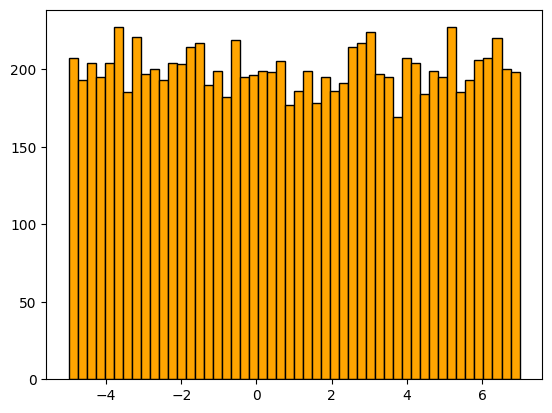

In [40]:
import matplotlib.pyplot as plt
A = numpy.random.uniform(low=-5.0, high=+7.0, size=10000)
plt.hist(A, bins=50, color="orange", edgecolor="black")
plt.show()

# Einen Sensor simulieren

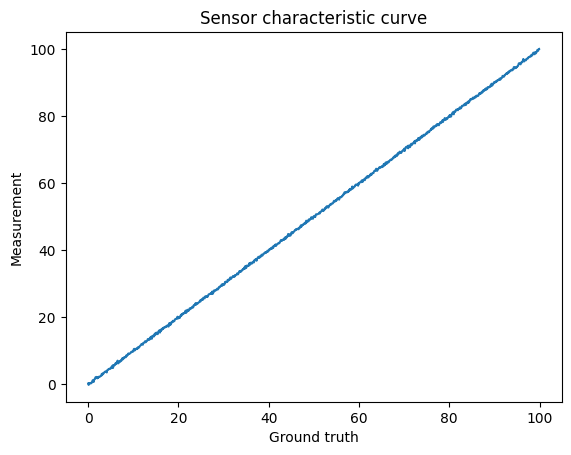

In [52]:
import numpy as np
import matplotlib.pyplot as plt

class Sensor:

    def __init__(self, variance):
        self.variance = variance

    def measure(self, ground_truth):
        noise = np.random.normal(loc=0.0, scale=self.variance)
        measurement = ground_truth + noise
        return measurement

    def measure_many(self, ground_truth, N):
        measurements = [self.measure(ground_truth) for _ in range(N)]
        return measurements

    def show_characteristic_curve(self, start, end, step=0.1):
        ground_truths = []
        measurements = []
        for ground_truth in np.arange(start,end,step):
            ground_truths.append( ground_truth )
            measurements.append( self.measure(ground_truth) )
            
        plt.plot(ground_truths, measurements)
        plt.title("Sensor characteristic curve")
        plt.xlabel("Ground truth")
        plt.ylabel("Measurement")
        plt.show()

    def __str__(self):
        return f"Distance sensor: variance={self.variance:.2f}"

    def __repr__(self):
        return str(self)
    

s1 = Sensor(0.2)
s2 = Sensor(0.5)
s3 = Sensor(1.5)

t = 50.0
N = 10

m1 = s1.measure_many(ground_truth=t, N=N)
s1.show_characteristic_curve(start=0.0, end=100.0)

In [53]:
m1

[49.88646597848392,
 49.819964360872696,
 50.22114253282569,
 49.83712061874503,
 49.88381554769503,
 50.23098300840213,
 49.764882236859634,
 50.064087461631665,
 50.31477678759238,
 49.86232174635195]

# Sensordatenfusion mittels Mittelwertschätzer

In [54]:
nr_sensors = 3
variance = 1.0
sensors = [Sensor(variance) for _ in range(nr_sensors)]

In [55]:
len(sensors)

3

In [56]:
sensors

[Distance sensor: variance=1.00,
 Distance sensor: variance=1.00,
 Distance sensor: variance=1.00]

In [59]:
gt = 50.0
multiple_measurements = [sensor.measure(gt) for sensor in sensors]
multiple_measurements

[50.45186327872361, 50.35577226079486, 48.381768071259366]

In [71]:
variance

1.0

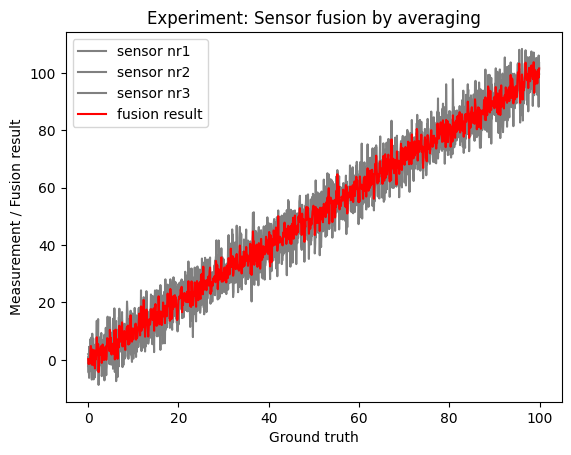

In [73]:
import numpy as np
import matplotlib.pyplot as plt

class SensorFusionAvg:

    def __init__(self, nr_sensors, variance):        
        self.nr_sensors = nr_sensors
        self.variance = variance
        self.sensors = [Sensor(variance) for _ in range(nr_sensors)]

    def measure_and_fuse(self, gt):
        measurements = [sensor.measure(gt) for sensor in self.sensors]
        avg = sum(measurements) / len(measurements)
        return measurements, avg

    def experiment(self, start, end, step=0.1):
        measurements_over_time = []
        fusion_results = []
        ground_truths = []
        for ground_truth in np.arange(start,end,step):
            measurements, avg = self.measure_and_fuse(ground_truth)
            ground_truths.append( ground_truth )
            measurements_over_time.append( measurements )
            fusion_results.append( avg )
        
        for sensor_nr in range(self.nr_sensors):
            meas_for_sensor = [v[sensor_nr] for v in measurements_over_time]
            plt.plot( ground_truths, meas_for_sensor,
                      label=f"sensor nr{sensor_nr+1}",
                      color="gray")
        plt.plot(ground_truths, fusion_results, label="fusion result", color="red")
        plt.title("Experiment: Sensor fusion by averaging")
        plt.xlabel("Ground truth")
        plt.ylabel("Measurement / Fusion result")
        plt.legend()
        plt.show()

f1 = SensorFusionAvg(nr_sensors=3, variance=5)
f1.experiment(start=0.0, end=100.0)